In [101]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import nltk
from nltk.tokenize import sent_tokenize

In [102]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [103]:
from flair.data import Sentence
#from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
#    TransformerWordEmbeddings, TransformerDocumentEmbeddings
from flair.embeddings import WordEmbeddings, \
    TransformerWordEmbeddings, TransformerDocumentEmbeddings

In [104]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

In [105]:
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

In [106]:
with open(os.path.join(localfolder, 'alice28-1476.txt'), 'r') as f:
    alice = ''.join(f.readlines()[104:3704])

with open(os.path.join(localfolder, 'wizoz10-1740.txt'), 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

In [107]:
print(alice[:500])
print('\n')
print(wizard[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w


                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking
cookstove, a cupboard for the dishes, a table, three or four
chairs, and

In [108]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(localfolder, 'lines.cfg'), 'w').write(text_cfg)

In [109]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [110]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liuxi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1612, 2240)

In [111]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

In [112]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

In [113]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True,
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]

    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})

    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None

        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)

        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)

    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

In [114]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liuxi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts\\alice28-1476.sent.csv', 'texts\\wizoz10-1740.sent.csv']

In [115]:
from datasets import load_dataset, Split

dataset = load_dataset(path='csv', data_files=new_fnames, quotechar='\\', split=Split.TRAIN)

Generating train split: 0 examples [00:00, ? examples/s]

In [116]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [117]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [118]:
dataset['source'][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

In [119]:
dataset.unique('source')

['alice28-1476.txt', 'wizoz10-1740.txt']

In [120]:
def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}

dataset = dataset.map(is_alice_label)

Map:   0%|          | 0/3852 [00:00<?, ? examples/s]

In [121]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'labels': 1}

In [122]:
shuffled_dataset = dataset.shuffle(seed=42)

In [123]:
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 771
    })
})

In [124]:
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [125]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [126]:
from gensim.parsing.preprocessing import *

preprocess_string(sentence)

['follow', 'white', 'rabbit']

In [127]:
filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

In [128]:
from gensim.utils import simple_preprocess

tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

In [129]:
sentences = train_dataset['sentence']
tokens = [simple_preprocess(sent) for sent in sentences]
tokens[0]

['uncle',
 'henry',
 'and',
 'aunt',
 'em',
 'had',
 'big',
 'bed',
 'in',
 'one',
 'corner',
 'and',
 'dorothy',
 'little',
 'bed',
 'in',
 'another',
 'corner']

In [130]:
from gensim import corpora

dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3715 unique tokens: ['and', 'another', 'aunt', 'bed', 'big']...>


In [131]:
dictionary.num_docs

3081

In [132]:
dictionary.num_pos # processed words

50572

In [133]:
dictionary.token2id

{'and': 0,
 'another': 1,
 'aunt': 2,
 'bed': 3,
 'big': 4,
 'corner': 5,
 'dorothy': 6,
 'em': 7,
 'had': 8,
 'henry': 9,
 'in': 10,
 'little': 11,
 'one': 12,
 'uncle': 13,
 'but': 14,
 'coming': 15,
 'decided': 16,
 'do': 17,
 'scarecrow': 18,
 'seen': 19,
 'the': 20,
 'them': 21,
 'to': 22,
 'what': 23,
 'woodman': 24,
 'at': 25,
 'her': 26,
 'hope': 27,
 'll': 28,
 'milk': 29,
 'of': 30,
 'remember': 31,
 'saucer': 32,
 'tea': 33,
 'they': 34,
 'time': 35,
 'asked': 36,
 'tin': 37,
 'hold': 38,
 'ma': 39,
 'tongue': 40,
 'your': 41,
 'around': 42,
 'brightest': 43,
 'china': 44,
 'colors': 45,
 'entirely': 46,
 'houses': 47,
 'made': 48,
 'many': 49,
 'painted': 50,
 'scattered': 51,
 'were': 52,
 'by': 53,
 'dark': 54,
 'door': 55,
 'down': 56,
 'floor': 57,
 'from': 58,
 'hole': 59,
 'into': 60,
 'it': 61,
 'ladder': 62,
 'led': 63,
 'middle': 64,
 'reached': 65,
 'small': 66,
 'trap': 67,
 'was': 68,
 'which': 69,
 'back': 70,
 'beasts': 71,
 'enemy': 72,
 'fear': 73,
 'for': 7

In [134]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['and', 'another', 'aunt', 'bed', 'big']

In [135]:
dictionary.cfs

{13: 10,
 9: 9,
 0: 2015,
 2: 21,
 7: 23,
 8: 356,
 4: 40,
 3: 23,
 10: 685,
 12: 186,
 5: 17,
 6: 289,
 11: 214,
 1: 41,
 14: 379,
 20: 3642,
 24: 132,
 19: 26,
 21: 248,
 15: 15,
 18: 172,
 16: 9,
 23: 181,
 22: 1483,
 17: 175,
 27: 10,
 34: 437,
 28: 52,
 31: 13,
 26: 533,
 32: 1,
 30: 1070,
 29: 3,
 25: 354,
 33: 16,
 35: 89,
 36: 110,
 37: 103,
 38: 14,
 41: 108,
 40: 5,
 39: 2,
 51: 1,
 42: 37,
 52: 244,
 49: 44,
 47: 8,
 48: 91,
 46: 7,
 44: 12,
 50: 13,
 43: 1,
 45: 1,
 61: 812,
 68: 692,
 65: 12,
 53: 113,
 67: 4,
 55: 47,
 64: 20,
 57: 15,
 58: 122,
 69: 93,
 62: 8,
 63: 14,
 56: 166,
 60: 118,
 66: 31,
 54: 13,
 59: 14,
 77: 139,
 85: 105,
 70: 113,
 81: 5,
 86: 76,
 71: 19,
 75: 32,
 84: 14,
 74: 371,
 76: 180,
 83: 631,
 82: 2,
 87: 702,
 79: 8,
 73: 11,
 72: 7,
 80: 168,
 78: 12,
 93: 7,
 94: 114,
 92: 5,
 96: 19,
 88: 24,
 95: 3,
 97: 24,
 89: 10,
 91: 49,
 90: 67,
 112: 769,
 100: 19,
 99: 21,
 115: 195,
 113: 25,
 109: 42,
 98: 257,
 101: 60,
 104: 84,
 107: 72,
 108: 

In [136]:
dictionary.dfs

{13: 10,
 9: 9,
 0: 1300,
 2: 21,
 7: 22,
 8: 307,
 4: 40,
 3: 21,
 10: 587,
 12: 173,
 5: 16,
 6: 284,
 11: 199,
 1: 41,
 14: 367,
 20: 1856,
 24: 130,
 19: 26,
 21: 224,
 15: 15,
 18: 172,
 16: 9,
 23: 175,
 22: 1069,
 17: 171,
 27: 10,
 34: 336,
 28: 47,
 31: 13,
 26: 386,
 32: 1,
 30: 808,
 29: 3,
 25: 325,
 33: 14,
 35: 86,
 36: 110,
 37: 102,
 38: 14,
 41: 101,
 40: 5,
 39: 2,
 51: 1,
 42: 36,
 52: 208,
 49: 43,
 47: 8,
 48: 90,
 46: 7,
 44: 9,
 50: 11,
 43: 1,
 45: 1,
 61: 607,
 68: 548,
 65: 12,
 53: 108,
 67: 4,
 55: 46,
 64: 20,
 57: 15,
 58: 121,
 69: 88,
 62: 8,
 63: 14,
 56: 154,
 60: 111,
 66: 31,
 54: 13,
 59: 14,
 77: 137,
 85: 104,
 70: 112,
 81: 5,
 86: 76,
 71: 19,
 75: 31,
 84: 14,
 74: 337,
 76: 157,
 83: 621,
 82: 2,
 87: 541,
 79: 8,
 73: 11,
 72: 7,
 80: 158,
 78: 12,
 93: 7,
 94: 109,
 92: 5,
 96: 19,
 88: 24,
 95: 3,
 97: 24,
 89: 10,
 91: 49,
 90: 66,
 112: 503,
 100: 19,
 99: 21,
 115: 183,
 113: 25,
 109: 37,
 98: 238,
 101: 56,
 104: 77,
 107: 70,
 108: 25

In [137]:
sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[2481, 20, 786, 109]


In [138]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

In [139]:
def get_rare_ids(dictionary, min_freq):
    rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
    return rare_ids

In [140]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)
    # removes rare words (in case the vocab size still
    # includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [141]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'], min_freq=2)

In [142]:
from transformers import BertTokenizer

tokenizer = BertTokenizer('our_vocab/vocab.txt')

In [143]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

In [144]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1124, 5, 207, 185, 1]

In [145]:
new_ids = tokenizer.encode(new_sentence)
new_ids

[3, 1124, 5, 207, 185, 1, 2]

In [146]:
tokenizer.convert_ids_to_tokens(new_ids)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]']

In [147]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

In [148]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

In [149]:
from gensim import downloader
glove = downloader.load('glove-wiki-gigaword-50')
len(glove.key_to_index)

400000

In [150]:
glove['alice']

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

In [151]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']

In [152]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634971141815186)]

In [153]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3717

In [154]:
unknown_words = sorted(list(set(vocab).difference(set(glove.key_to_index))))

In [155]:
print(len(unknown_words))
print(unknown_words[:5])

39
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


In [156]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
unknown_count, dictionary.num_pos

(82, 50572)

In [157]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    # UPDATED
    ###########################################################
    # The vocab property isn't available anymore at the newer
    # Gensim version. It was replaced by key_to_index
    # unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.vocab))))
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.key_to_index))))
    ###########################################################
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [158]:
vocab_coverage(dictionary, glove)

0.9983785493949221

In [159]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # UPDATED
    ###########################################################
    # The index2word property isn't available anymore at the 
    # newer Gensim version. It was replaced by index_to_key
    # words = wv.index2word
    words = wv.index_to_key
    ###########################################################
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w', encoding='utf-8') as f:
        for word in words:
            f.write(f'{word}\n')

In [160]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

In [161]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

In [162]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=False)

[7101, 930, 2, 300, 12427]

In [163]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

In [164]:
special_embeddings = np.zeros((2, glove.vector_size))

In [165]:
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [166]:
alice_idx = glove_tokenizer.encode('alice', add_special_tokens=False)
np.all(extended_embeddings[alice_idx] == glove['alice'])

True

In [167]:
train_sentences = train_dataset['sentence']
train_labels = train_dataset['labels']

test_sentences = test_dataset['sentence']
test_labels = test_dataset['labels']

In [168]:
train_ids = glove_tokenizer(train_sentences,
                            truncation=True,
                            padding=True,
                            max_length=60,
                            add_special_tokens=False,
                            return_tensors='pt')['input_ids']
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(test_sentences,
                           truncation=True,
                           padding=True,
                           max_length=60,
                           add_special_tokens=False,
                           return_tensors='pt')['input_ids']
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [169]:
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

In [170]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [171]:
token_ids, labels = next(iter(train_loader))
token_ids

tensor([[   10,    43,  1908,  ...,     0,     0,     0],
        [  934,    43,    59,  ...,     0,     0,     0],
        [   43,    59, 31721,  ...,    47,    13,    13],
        ...,
        [  129,     3,    19,  ...,     0,     0,     0],
        [   18,  7101, 78382,  ...,     0,     0,     0],
        [14399,   807,    59,  ...,     0,     0,     0]])

In [172]:
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

In [173]:
token_embeddings.mean(dim=1)

tensor([[ 0.0503,  0.0414, -0.0646,  ..., -0.0716,  0.0272,  0.1482],
        [ 0.1859,  0.2068,  0.0444,  ..., -0.1523,  0.0009,  0.2372],
        [ 0.1911,  0.1693, -0.1015,  ..., -0.2813, -0.0211,  0.0398],
        ...,
        [ 0.1022,  0.0291, -0.0062,  ..., -0.1670, -0.0049, -0.1283],
        [ 0.0075, -0.0104, -0.0117,  ..., -0.0124,  0.0106,  0.0322],
        [-0.0165,  0.0310,  0.0264,  ..., -0.0249,  0.0146,  0.0332]])

In [174]:
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode='mean')
boe_mean(token_ids)

tensor([[ 0.0503,  0.0414, -0.0646,  ..., -0.0716,  0.0272,  0.1482],
        [ 0.1859,  0.2068,  0.0444,  ..., -0.1523,  0.0009,  0.2372],
        [ 0.1911,  0.1693, -0.1015,  ..., -0.2813, -0.0211,  0.0398],
        ...,
        [ 0.1022,  0.0291, -0.0062,  ..., -0.1670, -0.0049, -0.1283],
        [ 0.0075, -0.0104, -0.0117,  ..., -0.0124,  0.0106,  0.0322],
        [-0.0165,  0.0310,  0.0264,  ..., -0.0249,  0.0146,  0.0332]])

In [175]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(
    extended_embeddings, mode='mean'
)
torch.manual_seed(41)
model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [176]:
sbs_emb = StepByStep(model, loss_fn, optimizer)
sbs_emb.set_loaders(train_loader, test_loader)
sbs_emb.train(20)

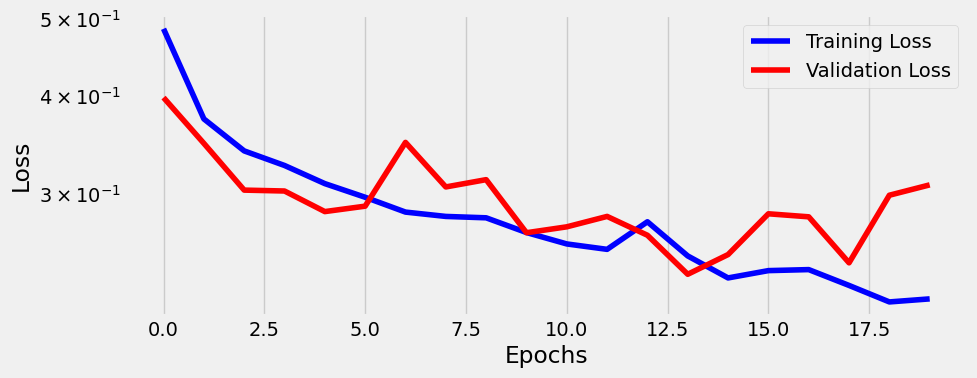

In [177]:
fig = sbs_emb.plot_losses()

In [178]:
StepByStep.loader_apply(test_loader, sbs_emb.correct)

tensor([[433, 446],
        [247, 325]])

In [179]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [180]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [181]:
sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

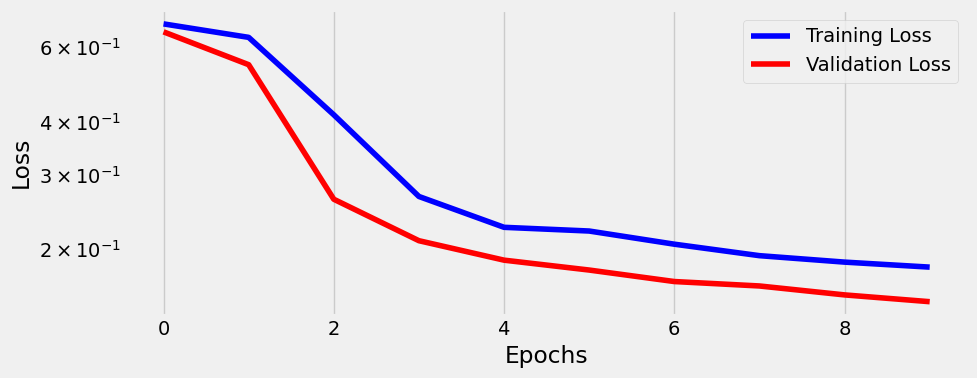

In [182]:
fig = sbs_transf.plot_losses()

In [183]:
StepByStep.loader_apply(test_loader, sbs_transf.correct)

tensor([[430, 446],
        [292, 325]])

In [184]:
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
"""

watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [185]:
from flair.data import Sentence

flair_sentences = [Sentence(s) for s in sentences]
flair_sentences[0]

Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear."

In [186]:
flair_sentences[0].get_token(32)

Token[31]: "watch"

In [188]:
from flair.embeddings import FlairEmbeddings
flair_emb = FlairEmbeddings('news-forward')

2024-03-09 20:45:12,095 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to C:\Users\liuxi\AppData\Local\Temp\tmpzh3khlbg


100%|█████████████████████████████████████████████████████████████████████████████| 69.7M/69.7M [27:23<00:00, 44.4kB/s]

2024-03-09 21:12:37,432 copying C:\Users\liuxi\AppData\Local\Temp\tmpzh3khlbg to cache at C:\Users\liuxi\.flair\embeddings\news-forward-0.4.1.pt
2024-03-09 21:12:37,466 removing temp file C:\Users\liuxi\AppData\Local\Temp\tmpzh3khlbg


In [189]:
flair_emb.embed(flair_sentences)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]